# Setup environment

In [1]:
import os
import numpy as np
import pandas as pd
pd.set_option('display.precision', 10)
import matplotlib.pyplot as plt
from datetime import datetime
from pytz import timezone
import copy
import pathlib
import pickle

from sklearn.metrics import mean_squared_error, mean_absolute_error, root_mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split

from src.lightgbm_wrapper.feature_engineer import add_time_features, add_lag_features, add_rolling_features
from src.lightgbm_wrapper.plot import plot_1_data, plot_2_data
from src.lightgbm_wrapper.station_embedding import learn_station_embeddings, attach_station_embedding
from src.lightgbm_wrapper.model import build_supervised_for_horizon, train_test_validation_split, train_lgbm_for_horizon, plot_timeseries_example
import torch

try:
    import lightgbm as lgb
except:
    print("lightgbm is not installed")

DATA_DIR = "/le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project/dataset/merged-data/by-station"
STATION_IDS = [211, 212, 213, 214, 215, 216]
#STATION_IDS = [211, 212, 213, 216]

BASE_FEATURE_COLS = [
    "NO2_quantrac",
    "PM25_quantrac",
    "O3_quantrac",
    "CO_quantrac",
    "SO2_quantrac",
]

# Define lag and rolling windows for feature engineering
LAG_STEPS = [3, 6, 12, 24, 48, 72]
ROLL_WINDOWS = [3, 6, 12, 24, 48, 72]

# Define horizon (= n_past = n_future)
HORIZONS = [1, 24, 48, 72]

model_path = "/le_thanh_van_118/workspace/hiep_workspace/lightgbm_results/so2_testing_model/"

# Load dataset

In [2]:
def load_station_csv(station_id, data_dir=DATA_DIR):
    csv_path = os.path.join(data_dir, f"{station_id}.csv")
    df = pd.read_csv(csv_path)

    # Convert to datetime
    df["date"] = pd.to_datetime(df["date"])
    df = df.sort_values("date").reset_index(drop=True)

    # Remove unncessary column
    if "Unnamed: 0" in df.columns:
        df = df.drop(columns=["Unnamed: 0"])

    # Add station_id column
    df["station_id"] = station_id
    return df

# Load dataset
dfs = []
for sid in STATION_IDS:
    df_sid = load_station_csv(sid, DATA_DIR)
    dfs.append(df_sid)
df_all = pd.concat(dfs, ignore_index=True)

# Sort data by station then date
df_all = df_all.sort_values(["station_id", "date"]).reset_index(drop=True)

# Remove uncessary features
df_all = df_all.loc[:, ["date"] + BASE_FEATURE_COLS + ["station_id"]]

print(df_all.shape)
print(df_all.columns)
df_all

(92966, 7)
Index(['date', 'NO2_quantrac', 'PM25_quantrac', 'O3_quantrac', 'CO_quantrac',
       'SO2_quantrac', 'station_id'],
      dtype='object')


,date,NO2_quantrac,PM25_quantrac,O3_quantrac,CO_quantrac,SO2_quantrac,station_id
0,2021-02-23 21:00:00,112.7407619000,15.6047619000,55.4313809500,90.0000000000,NaN,211
1,2021-02-23 22:00:00,112.3664706000,14.5941176500,58.1971764700,1200.6035290000,NaN,211
2,2021-02-23 23:00:00,112.7004333000,13.4366666700,55.0294333300,1177.8970000000,NaN,211
3,2021-02-24 00:00:00,112.4808667000,12.3650000000,54.7677000000,90.0000000000,NaN,211
4,2021-02-24 01:00:00,114.3315000000,11.6366666700,53.7862000000,90.0000000000,NaN,211
...,...,...,...,...,...,...,...
92961,2022-12-31 19:00:00,0.0882333333,41.4500000000,75.9166666667,2.0871666667,0.1056666667,216
92962,2022-12-31 20:00:00,0.0832166667,50.5300000000,66.1166666667,2.0065000000,0.1041666667,216
92963,2022-12-31 21:00:00,0.0843000000,55.0550000000,55.1333333333,2.4188333333,0.1301666667,216
92964,2022-12-31 22:00:00,0.0666500000,26.0783333333,46.7500000000,1.4815000000,0.0758333333,216


In [3]:
df_all.isnull().sum()

date                 0
NO2_quantrac     43684
PM25_quantrac    43043
O3_quantrac      47797
CO_quantrac      43760
SO2_quantrac     75946
station_id           0
dtype: int64

# Data preparation

## Drop missing

Output: df_dropped

In [4]:
df_dropped_na = df_all.dropna().reset_index(drop=True)

df_dropped = df_dropped_na.reset_index(drop=True)
df_dropped

,date,NO2_quantrac,PM25_quantrac,O3_quantrac,CO_quantrac,SO2_quantrac,station_id
0,2022-01-01 00:00:00,0.0380594966,27.6018890911,47.3061232901,0.9104147390,0.0561857079,214
1,2022-01-01 01:00:00,0.0363000000,21.2850000000,44.9166666667,0.6725000000,0.0425000000,214
2,2022-01-01 02:00:00,0.0347592593,18.4148148148,46.1481481481,0.5770370370,0.0359259259,214
3,2022-01-01 03:00:00,0.0356428571,19.2428571429,46.3571428571,0.5421428571,0.0302380952,214
4,2022-01-01 04:00:00,0.0365500000,18.1400000000,46.7000000000,0.5070000000,0.0296666667,214
...,...,...,...,...,...,...,...
13614,2022-12-31 19:00:00,0.0882333333,41.4500000000,75.9166666667,2.0871666667,0.1056666667,216
13615,2022-12-31 20:00:00,0.0832166667,50.5300000000,66.1166666667,2.0065000000,0.1041666667,216
13616,2022-12-31 21:00:00,0.0843000000,55.0550000000,55.1333333333,2.4188333333,0.1301666667,216
13617,2022-12-31 22:00:00,0.0666500000,26.0783333333,46.7500000000,1.4815000000,0.0758333333,216


## Update the STATION_IDS after dropping missing

In [5]:
STATION_IDS = list(df_dropped["station_id"].unique())
STATION_IDS

[214, 216]

## Visualization

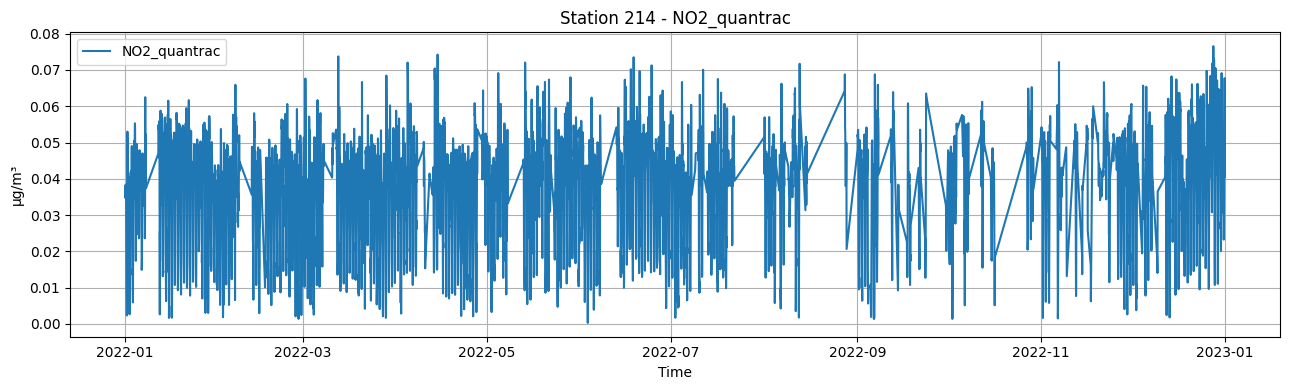

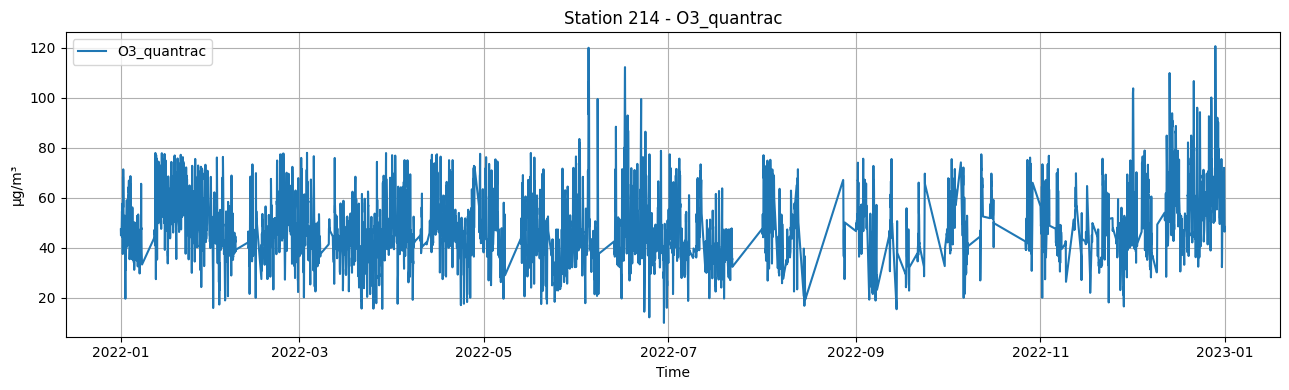

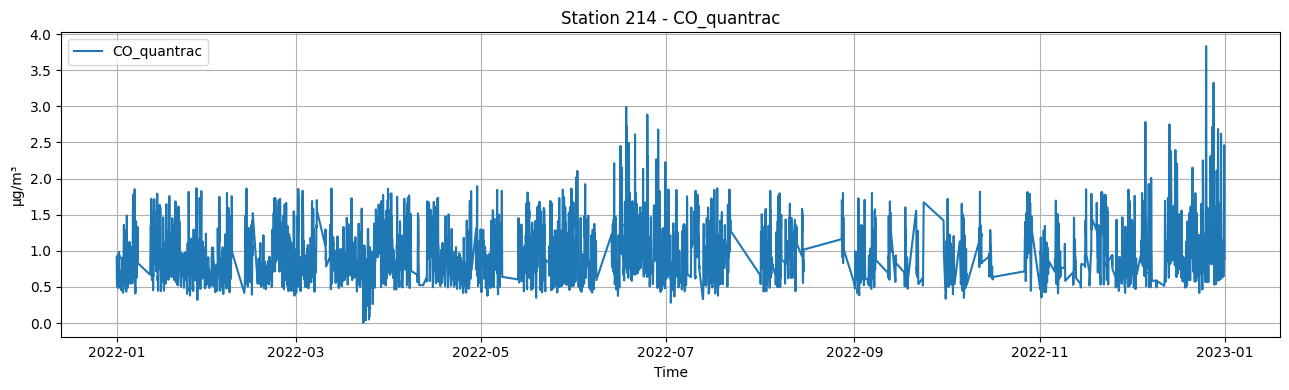

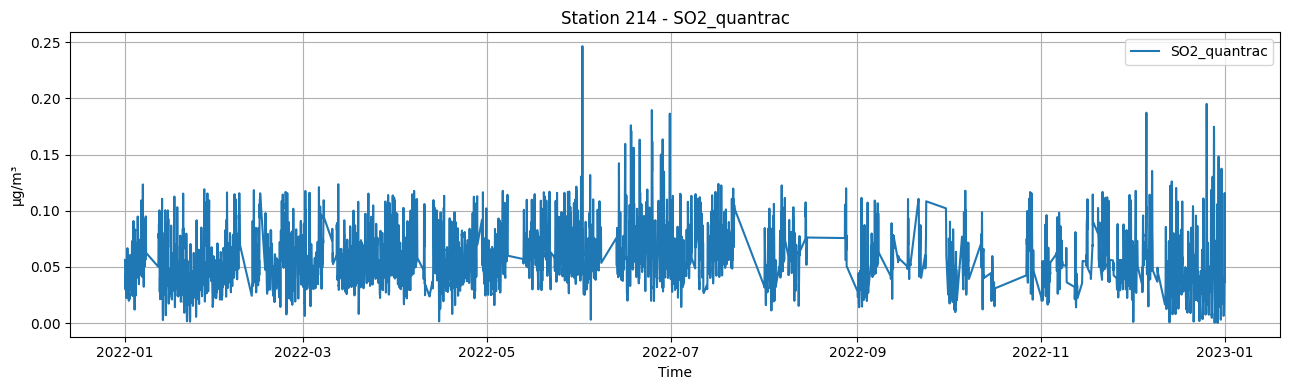

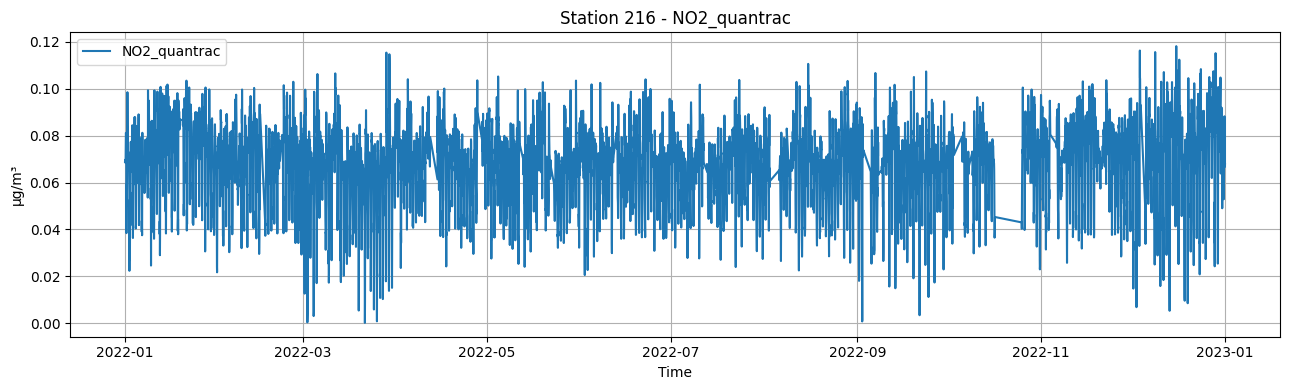

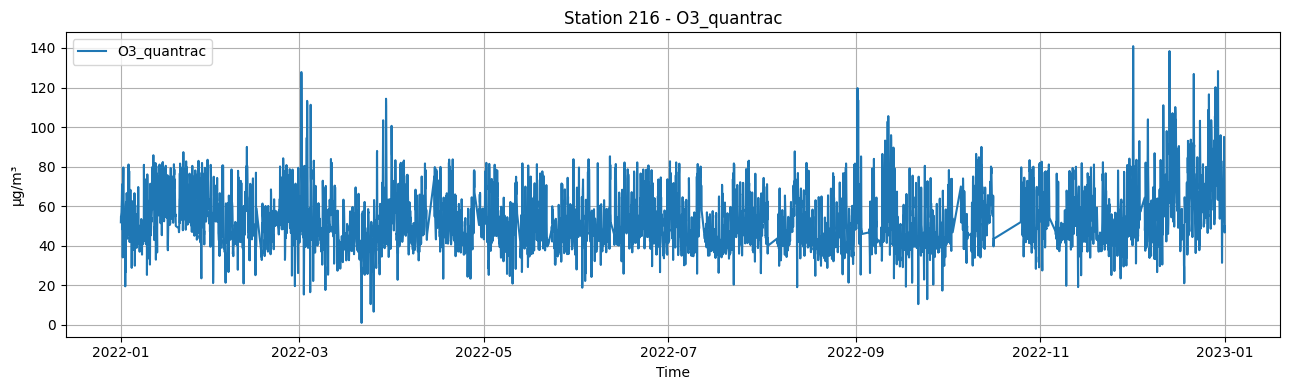

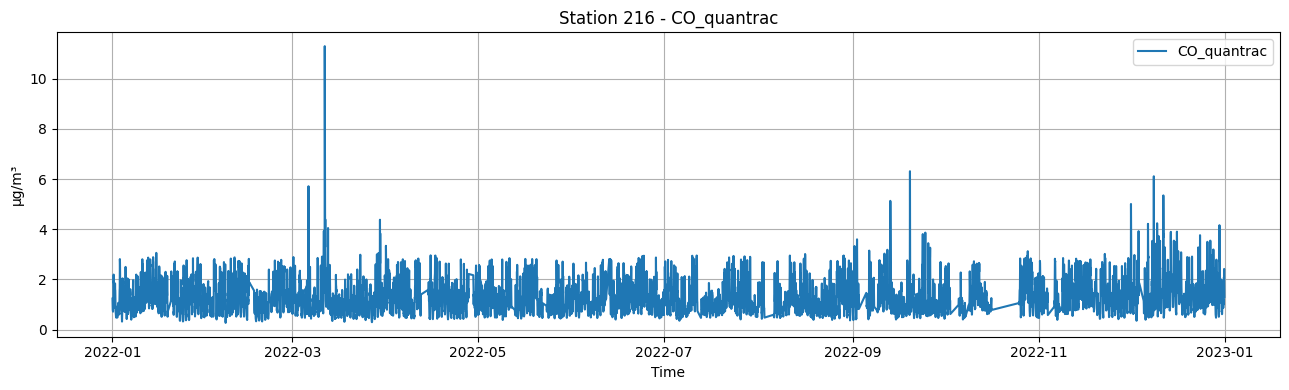

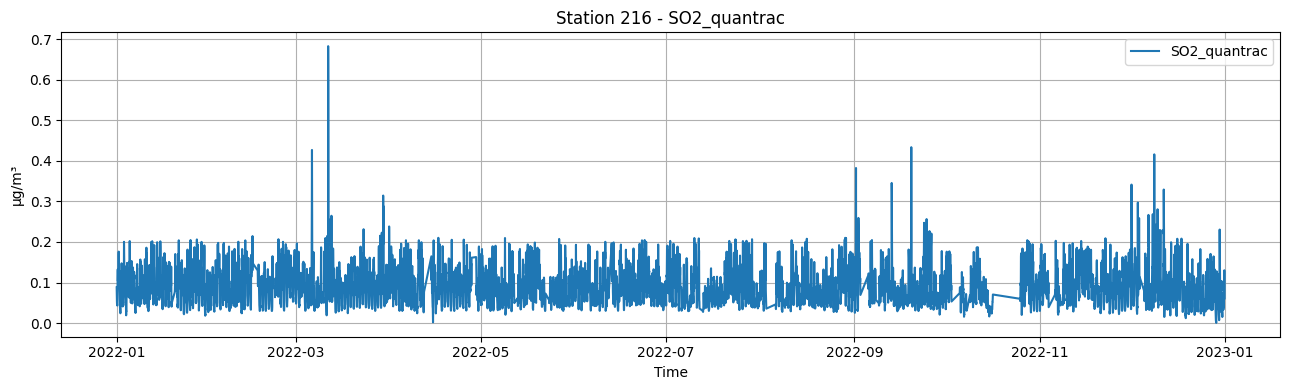

In [6]:
for station in STATION_IDS:
    df_station = df_dropped[df_dropped["station_id"] == station]
    for target_col in df_station.columns:
        if target_col not in ["date", "station_id", "Temperature_quantrac", "Humid_quantrac", "PM25_quantrac"]:
            plot_1_data(df_station, target_col, target_col, df_station["date"], f"Station {station} - {target_col}")
            #plot_1_data(df_station, target_col, target_col, df_station.index, f"Station {station} - {target_col}")
    print("\n" + "=" * 150 + "\n")

## Convert ppm to ug/m3

Apply only to station 216, year 2022 on NO2, CO columns

Output: df_converted

In [7]:
df_converted = copy.deepcopy(df_dropped)
mask = (df_converted["station_id"] == 216) & (df_converted["date"] >= "2022-01-01")
df_converted.loc[mask, "NO2_quantrac"] = df_converted.loc[mask, "NO2_quantrac"].apply(lambda x: x * 1883.2)
df_converted.loc[mask, "CO_quantrac"] = df_converted.loc[mask, "CO_quantrac"].apply(lambda x: x * 1146.8)
df_converted

,date,NO2_quantrac,PM25_quantrac,O3_quantrac,CO_quantrac,SO2_quantrac,station_id
0,2022-01-01 00:00:00,0.0380594966,27.6018890911,47.3061232901,0.9104147390,0.0561857079,214
1,2022-01-01 01:00:00,0.0363000000,21.2850000000,44.9166666667,0.6725000000,0.0425000000,214
2,2022-01-01 02:00:00,0.0347592593,18.4148148148,46.1481481481,0.5770370370,0.0359259259,214
3,2022-01-01 03:00:00,0.0356428571,19.2428571429,46.3571428571,0.5421428571,0.0302380952,214
4,2022-01-01 04:00:00,0.0365500000,18.1400000000,46.7000000000,0.5070000000,0.0296666667,214
...,...,...,...,...,...,...,...
13614,2022-12-31 19:00:00,166.1610133333,41.4500000000,75.9166666667,2393.5627333333,0.1056666667,216
13615,2022-12-31 20:00:00,156.7136266667,50.5300000000,66.1166666667,2301.0542000000,0.1041666667,216
13616,2022-12-31 21:00:00,158.7537600000,55.0550000000,55.1333333333,2773.9180666667,0.1301666667,216
13617,2022-12-31 22:00:00,125.5152800000,26.0783333333,46.7500000000,1698.9842000000,0.0758333333,216


## Visualization after converting unit

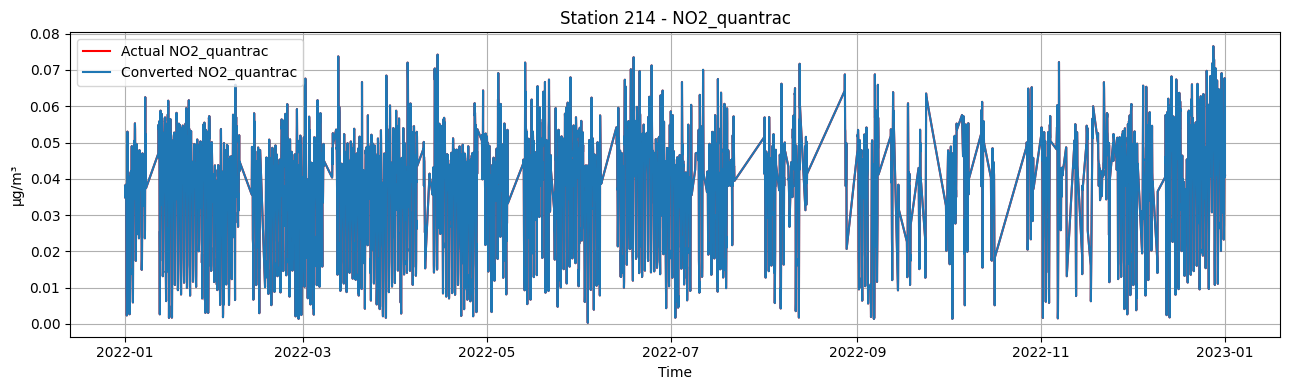

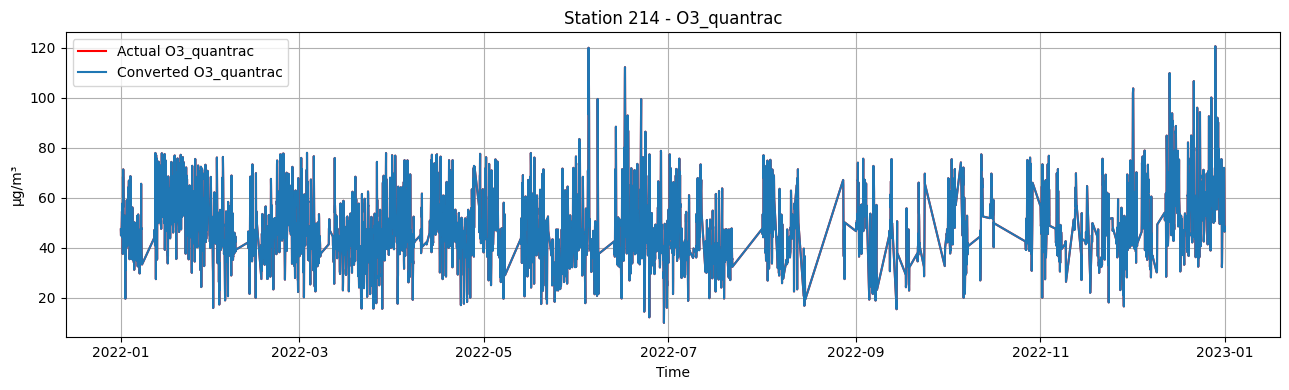

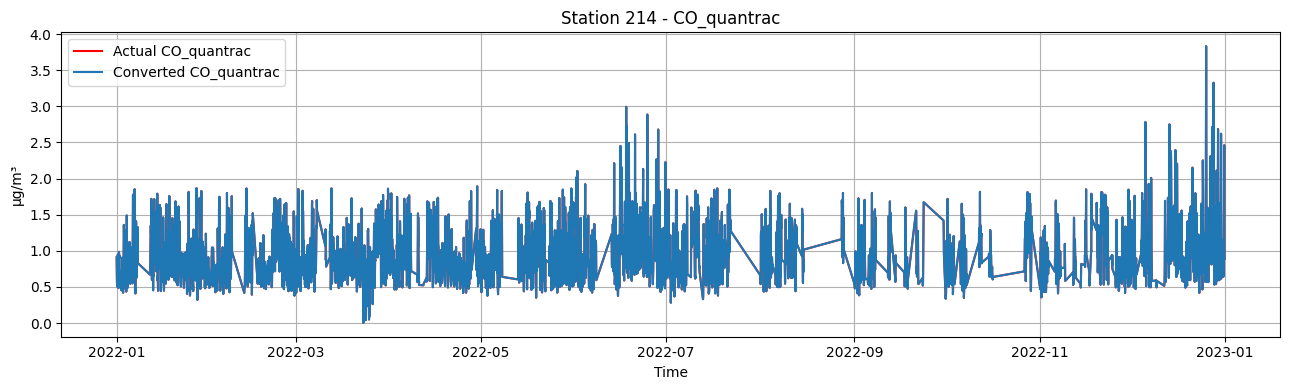

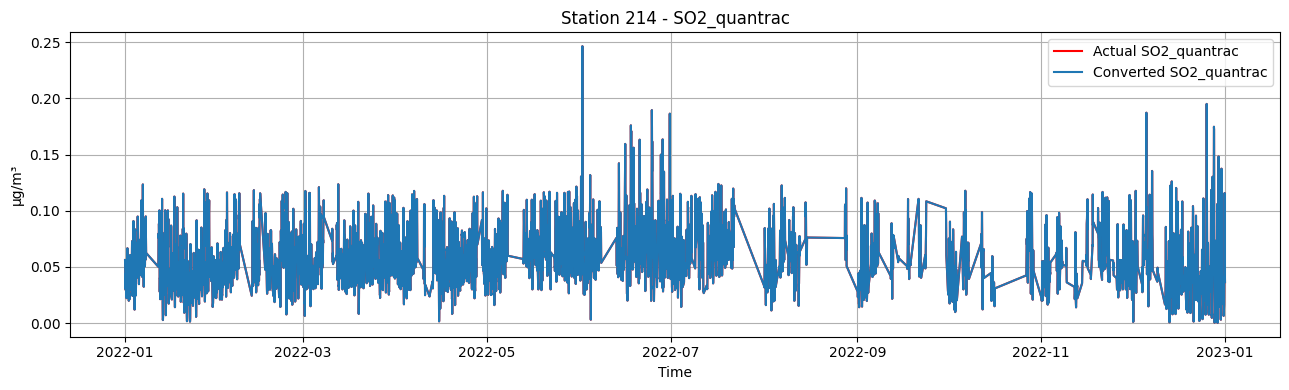

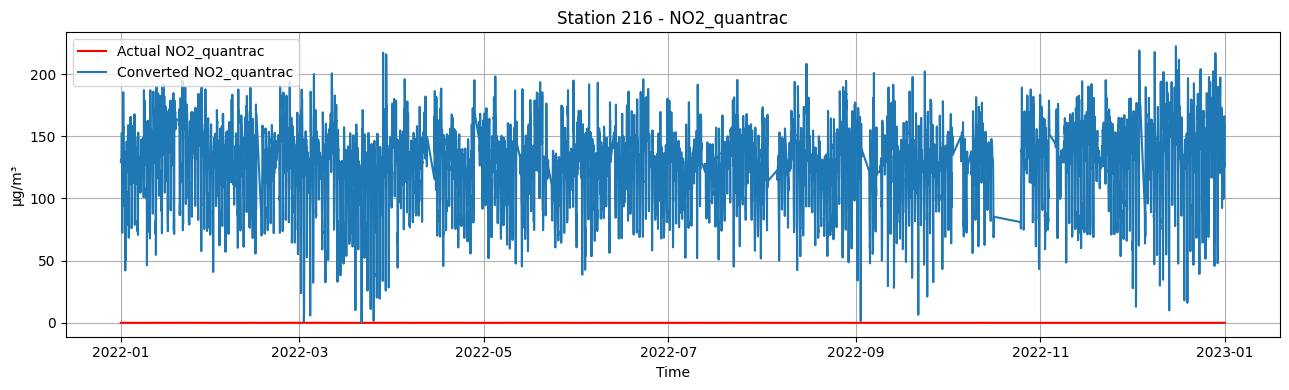

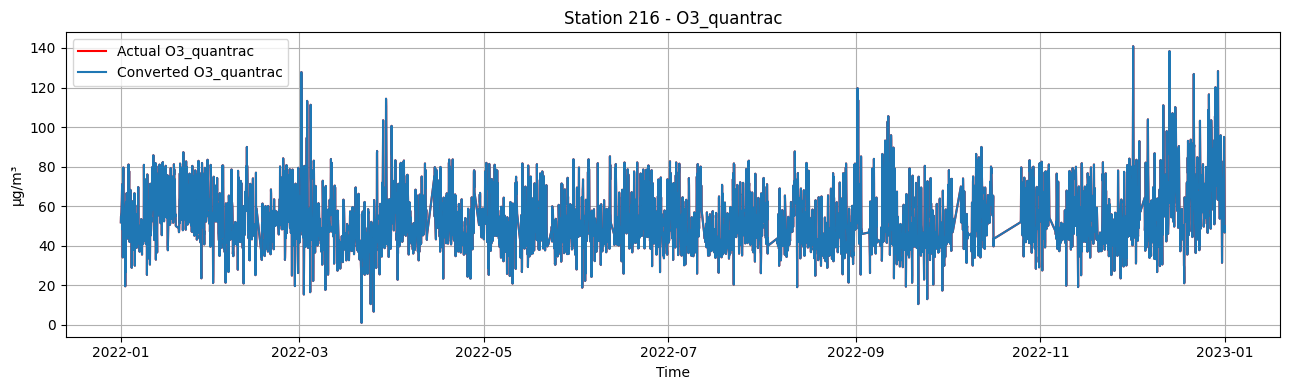

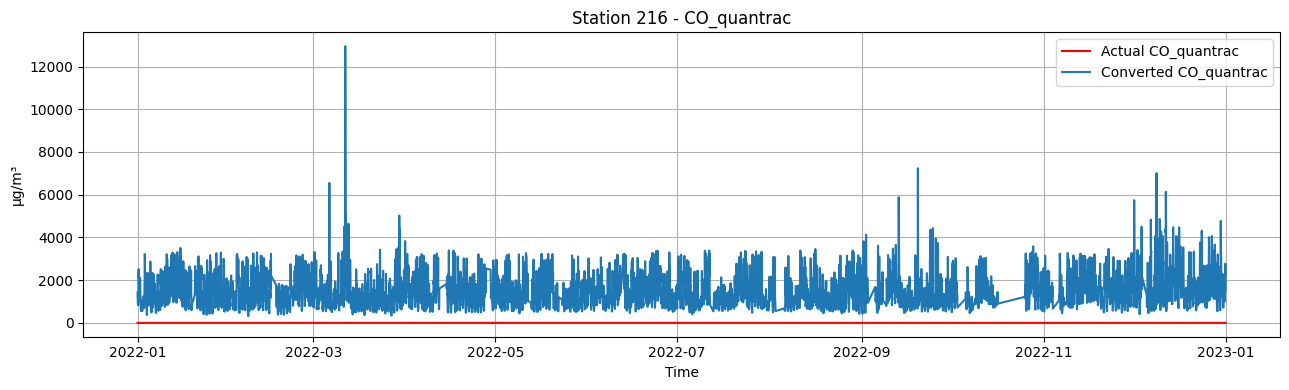

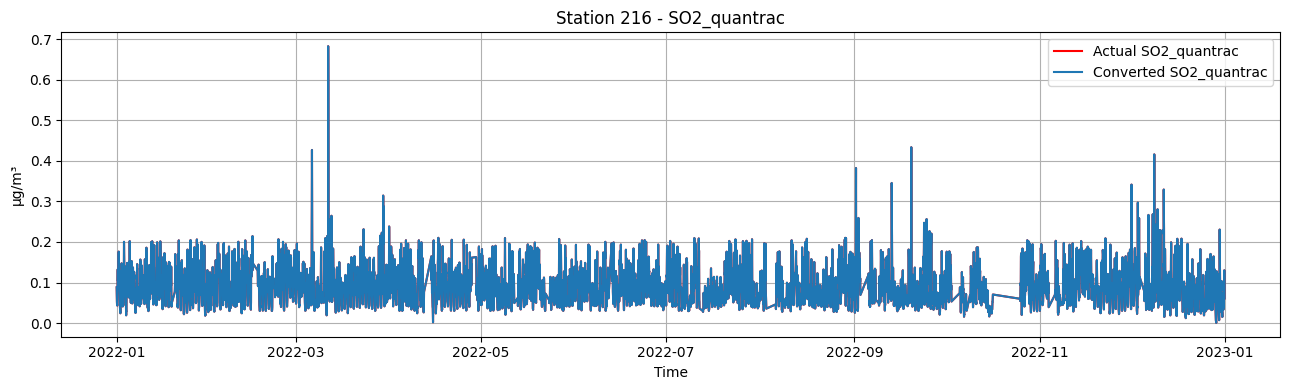

In [8]:
for station in STATION_IDS:
    df_station = df_dropped[df_dropped["station_id"] == station]
    df_station_converted = df_converted[df_converted["station_id"] == station]
    for target_col in df_station.columns:
        if target_col not in ["date", "station_id", "Temperature_quantrac", "Humid_quantrac", "PM25_quantrac"]:
            plot_2_data(df_station, target_col, f"Actual {target_col}",
                        df_station_converted, target_col, f"Converted {target_col}",
                        df_station["date"], f"Station {station} - {target_col}")
                        #df_station.index, f"Station {station} - {target_col}")
    print("\n" + "=" * 150 + "\n")

## Ugly hack to remove outliers

In [9]:
test = copy.deepcopy(df_converted)

lenbefore = len(test)
print(f"Before: {lenbefore} records")

# 214 SO2 quantrac
#test214 = test[test["station_id"] == 214]
#test = test.drop(index=test214[test214["SO2_quantrac"] > 120].index, errors="ignore")
#test = test.drop(index=test214[test214["O3_quantrac"] > 80].index, errors="ignore")

# 216 SO2 quantrac
test216 = test[test["station_id"] == 216]
#test = test.drop(index=test216[test216["SO2_quantrac"] > 700].index, errors="ignore")
test = test.drop(index=test216[test216["SO2_quantrac"] > 500].index, errors="ignore")
test = test.drop(index=test216[test216["O3_quantrac"] > 120].index, errors="ignore")

lenafter = len(test)
print(f"After: {lenafter} records")
print(f"Removed {lenbefore - lenafter} records")

df_converted = test.reset_index(drop=True)

Before: 13619 records
After: 13609 records
Removed 10 records


## Visualization after removing outliers

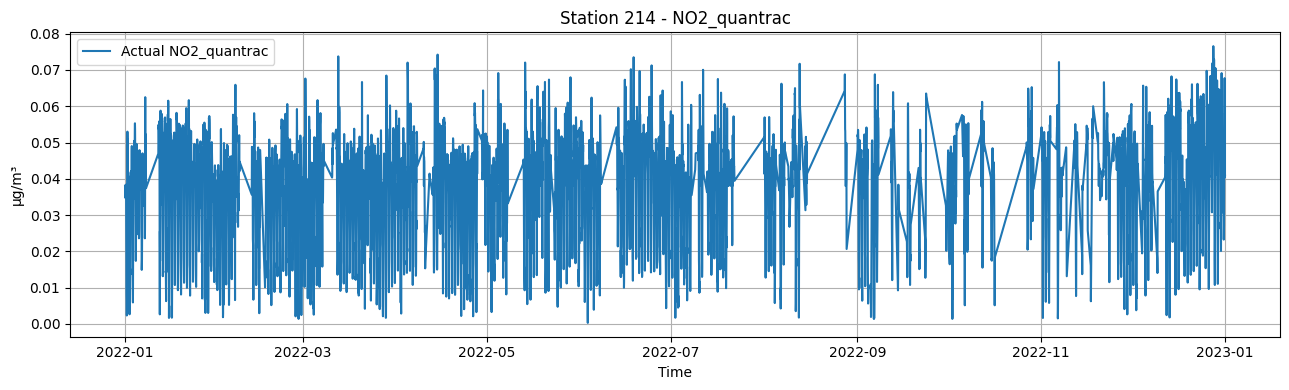

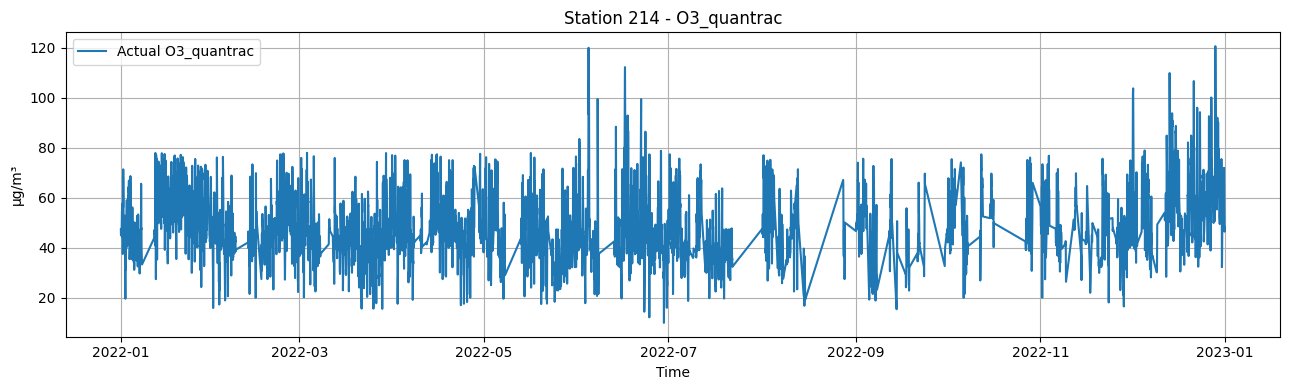

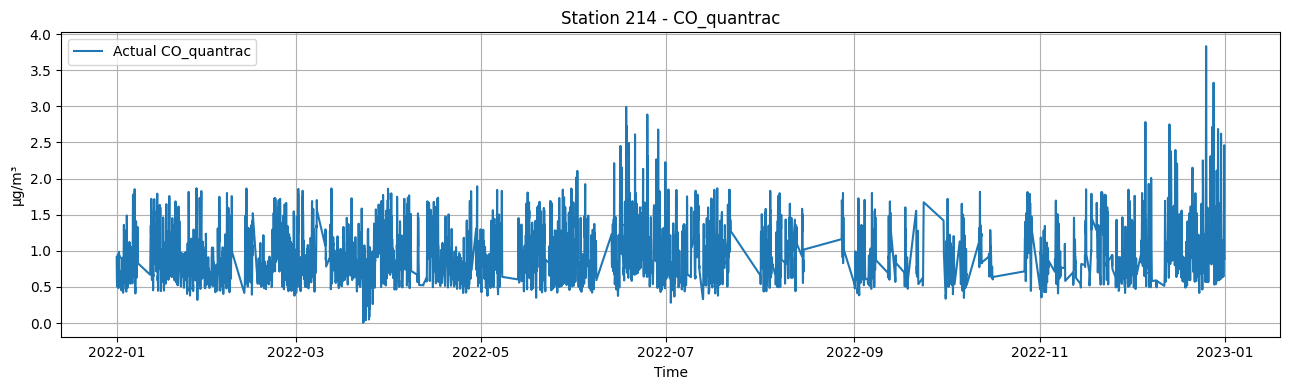

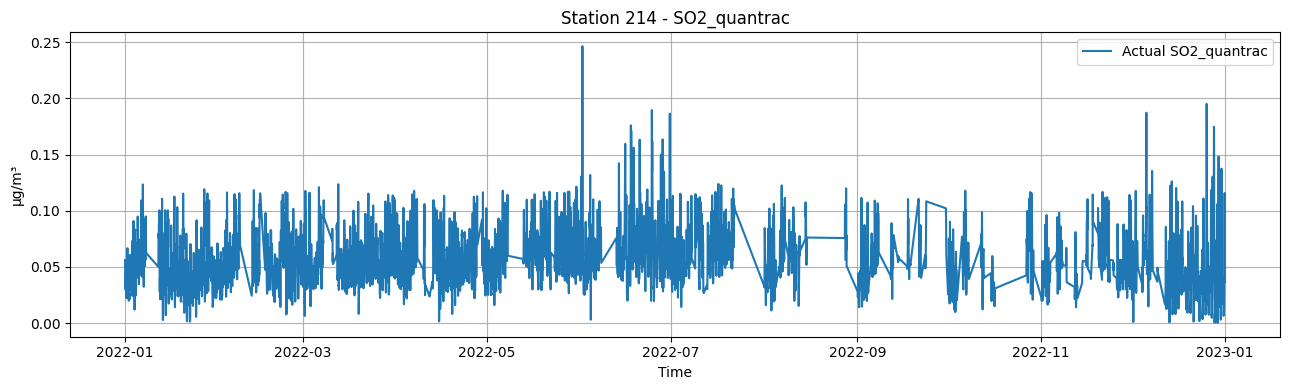

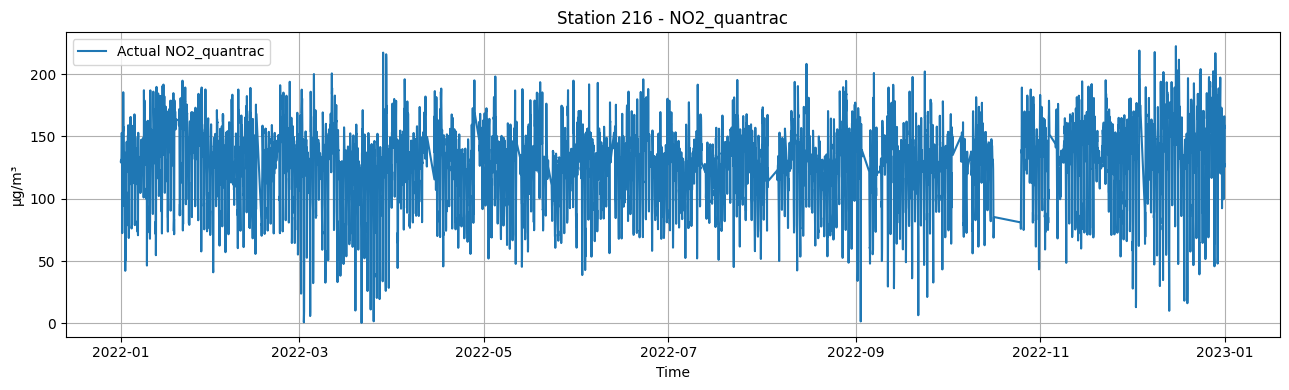

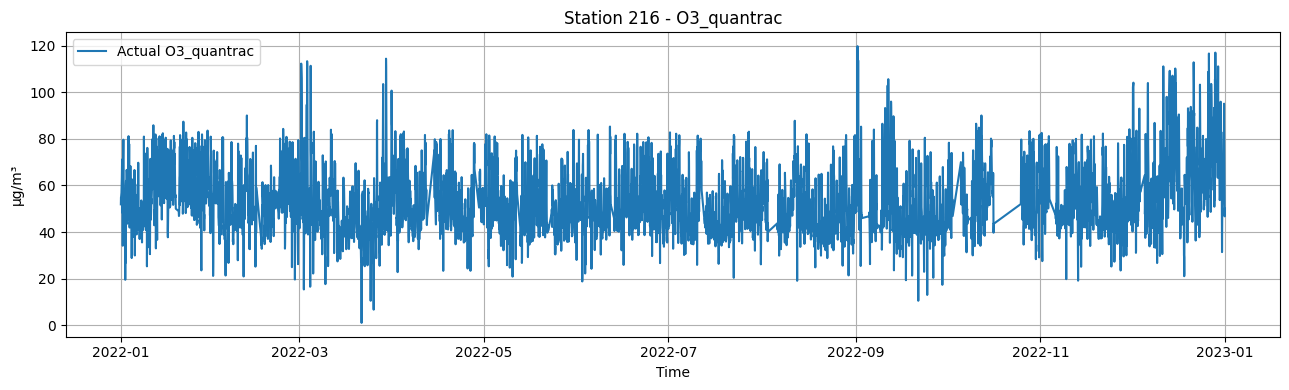

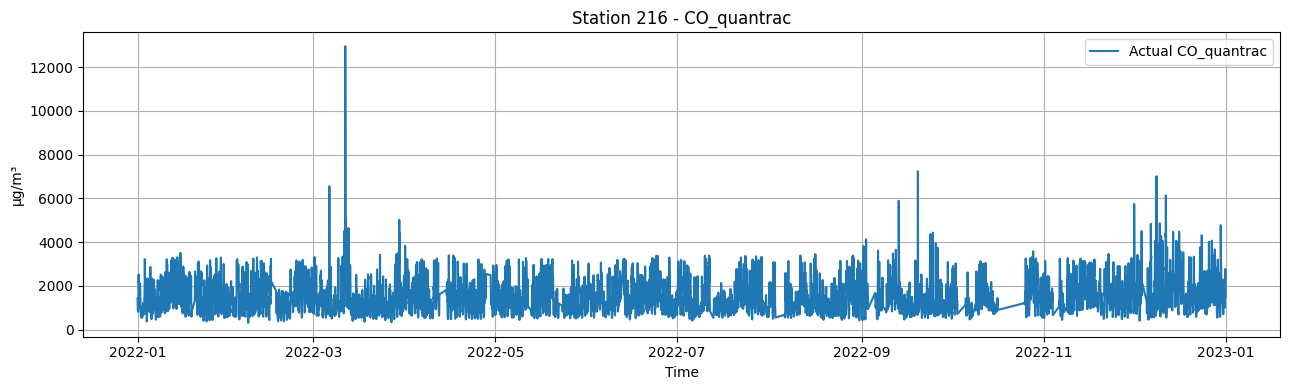

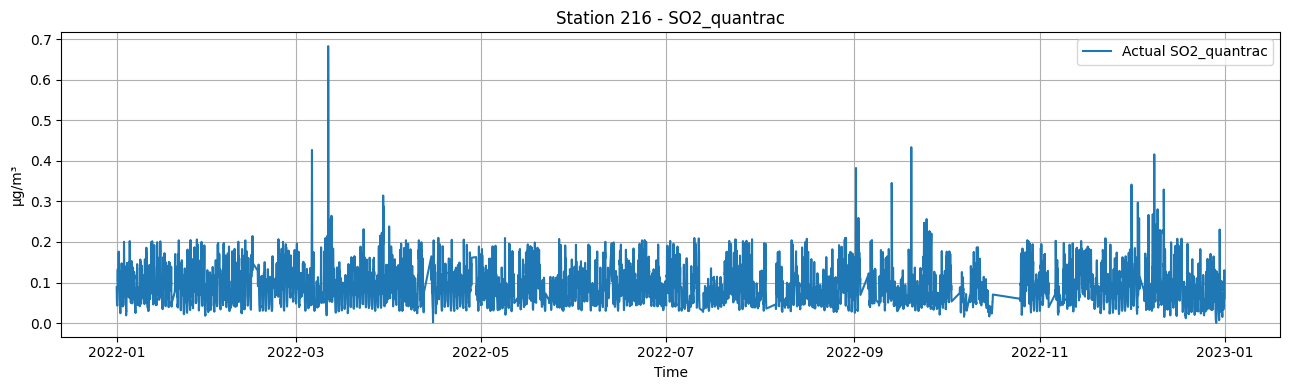

In [10]:
for station in STATION_IDS:
    df_station = df_converted[df_converted["station_id"] == station]
    for target_col in df_station.columns:
        if target_col not in ["date", "station_id", "Temperature_quantrac", "Humid_quantrac", "PM25_quantrac"]:
            plot_1_data(df_station, target_col, f"Actual {target_col}",
                        df_station["date"], f"Station {station} - {target_col}")
                        #df_station.index, f"Station {station} - {target_col}")
    print("\n" + "=" * 150 + "\n")

# Prepare test data with 73 records

In [11]:
df_test = df_converted.iloc[0:73]
df_test

,date,NO2_quantrac,PM25_quantrac,O3_quantrac,CO_quantrac,SO2_quantrac,station_id
0,2022-01-01 00:00:00,0.0380594966,27.6018890911,47.3061232901,0.9104147390,0.0561857079,214
1,2022-01-01 01:00:00,0.0363000000,21.2850000000,44.9166666667,0.6725000000,0.0425000000,214
2,2022-01-01 02:00:00,0.0347592593,18.4148148148,46.1481481481,0.5770370370,0.0359259259,214
3,2022-01-01 03:00:00,0.0356428571,19.2428571429,46.3571428571,0.5421428571,0.0302380952,214
4,2022-01-01 04:00:00,0.0365500000,18.1400000000,46.7000000000,0.5070000000,0.0296666667,214
...,...,...,...,...,...,...,...
68,2022-01-03 20:00:00,0.0450000000,20.4116666667,45.7833333333,1.0565000000,0.0825000000,214
69,2022-01-03 21:00:00,0.0361228070,20.2192982456,35.4035087719,0.7385964912,0.0629824561,214
70,2022-01-03 22:00:00,0.0370333333,17.5216666667,36.2333333333,0.6716666667,0.0511666667,214
71,2022-01-03 23:00:00,0.0385833333,16.5791666667,38.6041666667,0.5795833333,0.0500000000,214


In [12]:
data = {}
for col in df_test.columns:
    new_col = col.lower().replace("_quantrac", "")
    data[new_col] = [str(item) for item in df_test[col].to_list()]

for k,v in data.items():
    print(f'"{k}": ', end='')
    if k == "date":
        formatted_items = [f'"{item}"' for item in v]
        print(f"[{', '.join(formatted_items)}]")
    else:
        formatted_items = [f'{item}' for item in v]
        print(f"[{', '.join(formatted_items)}]")
    print("\n")

"date": ["2022-01-01 00:00:00", "2022-01-01 01:00:00", "2022-01-01 02:00:00", "2022-01-01 03:00:00", "2022-01-01 04:00:00", "2022-01-01 05:00:00", "2022-01-01 06:00:00", "2022-01-01 07:00:00", "2022-01-01 08:00:00", "2022-01-01 09:00:00", "2022-01-01 10:00:00", "2022-01-01 11:00:00", "2022-01-01 12:00:00", "2022-01-01 13:00:00", "2022-01-01 14:00:00", "2022-01-01 15:00:00", "2022-01-01 16:00:00", "2022-01-01 17:00:00", "2022-01-01 18:00:00", "2022-01-01 19:00:00", "2022-01-01 20:00:00", "2022-01-01 21:00:00", "2022-01-01 22:00:00", "2022-01-01 23:00:00", "2022-01-02 00:00:00", "2022-01-02 01:00:00", "2022-01-02 02:00:00", "2022-01-02 03:00:00", "2022-01-02 04:00:00", "2022-01-02 05:00:00", "2022-01-02 06:00:00", "2022-01-02 07:00:00", "2022-01-02 08:00:00", "2022-01-02 09:00:00", "2022-01-02 10:00:00", "2022-01-02 11:00:00", "2022-01-02 12:00:00", "2022-01-02 13:00:00", "2022-01-02 14:00:00", "2022-01-02 15:00:00", "2022-01-02 16:00:00", "2022-01-02 17:00:00", "2022-01-02 18:00:00", "2

# Start calling API

### Adding time/lag features

In [13]:
# Add time features and lag feature for all gases
df_time_feats = add_time_features(df_test)
df_lag_feats = add_lag_features(df_time_feats, group_col="station_id", target_cols=BASE_FEATURE_COLS, lag_steps=LAG_STEPS)

print(df_lag_feats.columns)
display(df_lag_feats)

Index(['date', 'NO2_quantrac', 'PM25_quantrac', 'O3_quantrac', 'CO_quantrac',
       'SO2_quantrac', 'station_id', 'hour', 'dayofweek', 'month',
       'NO2_quantrac_lag3', 'NO2_quantrac_lag6', 'NO2_quantrac_lag12',
       'NO2_quantrac_lag24', 'NO2_quantrac_lag48', 'NO2_quantrac_lag72',
       'PM25_quantrac_lag3', 'PM25_quantrac_lag6', 'PM25_quantrac_lag12',
       'PM25_quantrac_lag24', 'PM25_quantrac_lag48', 'PM25_quantrac_lag72',
       'O3_quantrac_lag3', 'O3_quantrac_lag6', 'O3_quantrac_lag12',
       'O3_quantrac_lag24', 'O3_quantrac_lag48', 'O3_quantrac_lag72',
       'CO_quantrac_lag3', 'CO_quantrac_lag6', 'CO_quantrac_lag12',
       'CO_quantrac_lag24', 'CO_quantrac_lag48', 'CO_quantrac_lag72',
       'SO2_quantrac_lag3', 'SO2_quantrac_lag6', 'SO2_quantrac_lag12',
       'SO2_quantrac_lag24', 'SO2_quantrac_lag48', 'SO2_quantrac_lag72'],
      dtype='object')


,date,NO2_quantrac,PM25_quantrac,O3_quantrac,CO_quantrac,SO2_quantrac,station_id,hour,dayofweek,month,...,CO_quantrac_lag12,CO_quantrac_lag24,CO_quantrac_lag48,CO_quantrac_lag72,SO2_quantrac_lag3,SO2_quantrac_lag6,SO2_quantrac_lag12,SO2_quantrac_lag24,SO2_quantrac_lag48,SO2_quantrac_lag72
0,2022-01-01 00:00:00,0.0380594966,27.6018890911,47.3061232901,0.9104147390,0.0561857079,214,0,5,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2022-01-01 01:00:00,0.0363000000,21.2850000000,44.9166666667,0.6725000000,0.0425000000,214,1,5,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2022-01-01 02:00:00,0.0347592593,18.4148148148,46.1481481481,0.5770370370,0.0359259259,214,2,5,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2022-01-01 03:00:00,0.0356428571,19.2428571429,46.3571428571,0.5421428571,0.0302380952,214,3,5,1,...,NaN,NaN,NaN,NaN,0.0561857079,NaN,NaN,NaN,NaN,NaN
4,2022-01-01 04:00:00,0.0365500000,18.1400000000,46.7000000000,0.5070000000,0.0296666667,214,4,5,1,...,NaN,NaN,NaN,NaN,0.0425000000,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,2022-01-03 20:00:00,0.0450000000,20.4116666667,45.7833333333,1.0565000000,0.0825000000,214,20,0,1,...,1.1648936170,0.7575609756,0.8920000000,NaN,0.0619642857,0.0320000000,0.0729787234,0.0417073171,0.0575000000,NaN
69,2022-01-03 21:00:00,0.0361228070,20.2192982456,35.4035087719,0.7385964912,0.0629824561,214,21,0,1,...,1.3593220339,0.6827450980,0.9358333333,NaN,0.0825000000,0.0268292683,0.0718644068,0.0370588235,0.0600000000,NaN
70,2022-01-03 22:00:00,0.0370333333,17.5216666667,36.2333333333,0.6716666667,0.0511666667,214,22,0,1,...,1.2202500000,0.6951666667,0.8850000000,NaN,0.0908928571,0.0408333333,0.0460000000,0.0365000000,0.0575000000,NaN
71,2022-01-03 23:00:00,0.0385833333,16.5791666667,38.6041666667,0.5795833333,0.0500000000,214,23,0,1,...,0.8478260870,0.7726666667,0.6833333333,NaN,0.0825000000,0.0619642857,0.0321739130,0.0338333333,0.0431666667,NaN


## SO2_quantrac

In [14]:
# Add rolling features for target_col
target_col = "SO2_quantrac"
df_so2 = add_rolling_features(df_lag_feats, group_col="station_id", target_cols=[target_col], windows=ROLL_WINDOWS)

# Add station embedding
with open(os.path.join(model_path, f"{target_col}_station_embedding.pkl"), "rb") as so2_emb_file:
    so2_station_to_embedding = pickle.load(so2_emb_file)
print(so2_station_to_embedding)
df_so2, _ = attach_station_embedding(df_so2, so2_station_to_embedding, station_col="station_id")

# Dropna
df_so2 = df_so2.dropna()
display(df_so2)

for horizon_h in HORIZONS:
    test_model = lgb.Booster(model_file=os.path.join(model_path, f"{target_col}_lightgbm_{horizon_h}h"))
    predicted_value = test_model.predict(df_so2.drop(columns=["station_id", "date", target_col]), num_iteration=getattr(test_model, "best_iteration", None))[0]
    print(f"Horizon: {horizon_h}h - predicted: {predicted_value}")

{214: [-3.2829216, -4.1803436, 4.157494, -3.935858], 216: [-4.7896767, -4.5424495, 6.1784797, -4.851963]}


,date,NO2_quantrac,PM25_quantrac,O3_quantrac,CO_quantrac,SO2_quantrac,station_id,hour,dayofweek,month,...,SO2_quantrac_roll24_mean,SO2_quantrac_roll24_std,SO2_quantrac_roll48_mean,SO2_quantrac_roll48_std,SO2_quantrac_roll72_mean,SO2_quantrac_roll72_std,station_emb_0,station_emb_1,station_emb_2,station_emb_3
72,2022-01-04,0.0383333333,15.3183333333,40.1,0.4666666667,0.0441666667,214,0,1,1,...,0.0494320802,0.0200686497,0.0417840894,0.0184049057,0.0420856288,0.0163787745,-3.2829215527,-4.1803436279,4.1574940681,-3.9358580112


Horizon: 1h - predicted: 92.84526834071501
Horizon: 24h - predicted: 109.25087733257021
Horizon: 48h - predicted: 118.20350423849332
Horizon: 72h - predicted: 117.73254783621249
